In [2]:
import hdbscan
import debacl
import fastcluster
import sklearn.cluster
import scipy.cluster
import sklearn.datasets
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context('poster')
sns.set_palette('Paired', 10)
sns.set_color_codes()

def benchmark_algorithm(dataset_sizes, cluster_function, function_args, function_kwds,
                        dataset_dimension=10, dataset_n_clusters=10, max_time=45, sample_size=2):

    # Initialize the result with NaNs so that any unfilled entries
    # will be considered NULL when we convert to a pandas dataframe at the end
    result = np.nan * np.ones((len(dataset_sizes), sample_size))
    for index, size in enumerate(dataset_sizes):
        for s in range(sample_size):
            # Use sklearns make_blobs to generate a random dataset with specified size
            # dimension and number of clusters
            data, labels = sklearn.datasets.make_blobs(n_samples=size,
                                                       n_features=dataset_dimension,
                                                       centers=dataset_n_clusters)

            # Start the clustering with a timer
            start_time = time.time()
            cluster_function(data, *function_args, **function_kwds)
            time_taken = time.time() - start_time

            # If we are taking more than max_time then abort -- we don't
            # want to spend excessive time on slow algorithms
            if time_taken > max_time:
                result[index, s] = time_taken
                return pd.DataFrame(np.vstack([dataset_sizes.repeat(sample_size),
                                               result.flatten()]).T, columns=['x','y'])
            else:
                result[index, s] = time_taken

    # Return the result as a dataframe for easier handling with seaborn afterwards
    return pd.DataFrame(np.vstack([dataset_sizes.repeat(sample_size),
                                   result.flatten()]).T, columns=['x','y'])

In [3]:
dataset_sizes = np.hstack([np.arange(1, 6) * 500, np.arange(3,7) * 1000, np.arange(4,17) * 2000])

In [8]:
k_means = sklearn.cluster.KMeans(10)
k_means_data = benchmark_algorithm(dataset_sizes, k_means.fit, (), {})

dbscan = sklearn.cluster.DBSCAN(eps=1.25)
dbscan_data = benchmark_algorithm(dataset_sizes, dbscan.fit, (), {})

scipy_k_means_data = benchmark_algorithm(dataset_sizes,
                                         scipy.cluster.vq.kmeans, (10,), {})

scipy_single_data = benchmark_algorithm(dataset_sizes,
                                        scipy.cluster.hierarchy.single, (), {})

fastclust_data = benchmark_algorithm(dataset_sizes,
                                     fastcluster.linkage_vector, (), {})

hdbscan_ = hdbscan.HDBSCAN()
hdbscan_data = benchmark_algorithm(dataset_sizes, hdbscan_.fit, (), {})

#debacl_data = benchmark_algorithm(dataset_sizes,
                                  #debacl.geom_tree.geomTree, (5, 5), {'verbose':False})

agglomerative = sklearn.cluster.AgglomerativeClustering(10)
agg_data = benchmark_algorithm(dataset_sizes,
                               agglomerative.fit, (), {}, sample_size=4)

spectral = sklearn.cluster.SpectralClustering(10)
spectral_data = benchmark_algorithm(dataset_sizes,
                                    spectral.fit, (), {}, sample_size=6)

affinity_prop = sklearn.cluster.AffinityPropagation()
ap_data = benchmark_algorithm(dataset_sizes,
                              affinity_prop.fit, (), {}, sample_size=3)

C:\Users\brain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\brain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\brain\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\U

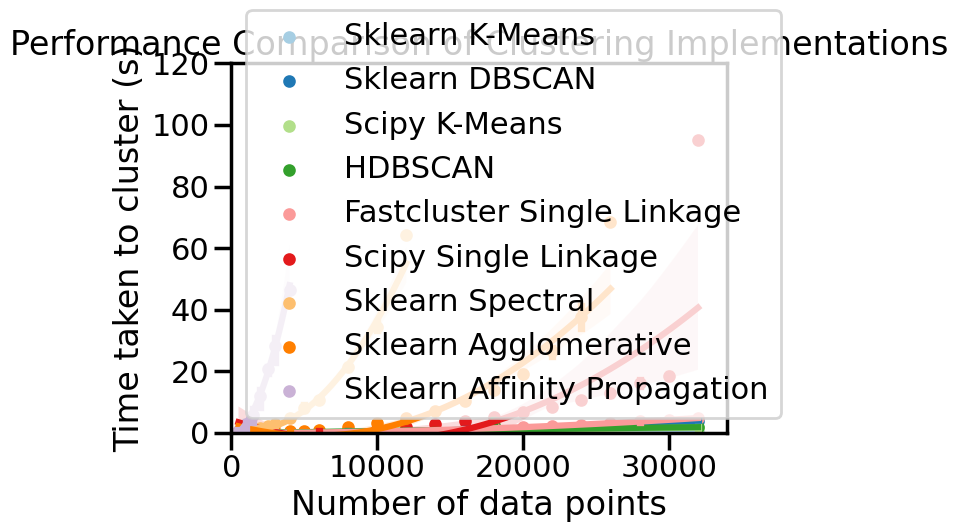

In [16]:
sns.regplot(x='x', y='y', data=k_means_data, order=2,
            label='Sklearn K-Means', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=dbscan_data, order=2,
            label='Sklearn DBSCAN', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=scipy_k_means_data, order=2,
            label='Scipy K-Means', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=hdbscan_data, order=2,
            label='HDBSCAN', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=fastclust_data, order=2,
            label='Fastcluster Single Linkage', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=scipy_single_data, order=2,
            label='Scipy Single Linkage', x_estimator=np.mean)
#sns.regplot(x='x', y='y', data=debacl_data, order=2,
#            label='DeBaCl Geom Tree', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=spectral_data, order=2,
            label='Sklearn Spectral', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=agg_data, order=2,
            label='Sklearn Agglomerative', x_estimator=np.mean)
sns.regplot(x='x', y='y', data=ap_data, order=2,
            label='Sklearn Affinity Propagation', x_estimator=np.mean)
plt.gca().axis([0, 34000, 0, 120])
plt.gca().set_xlabel('Number of data points')
plt.gca().set_ylabel('Time taken to cluster (s)')
plt.title('Performance Comparison of Clustering Implementations')
plt.legend()